# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos. 

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    

## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.1.0
Version 2, minor 1


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labelled images, used as follows

  >`data, labels = helper.getData()`
- scaleData: scale your input data

  >`X, y = helper.scaleData(data, labels)`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [7]:
# Load the helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import helper module
import helper
%aimport helper

helper = helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [9]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))

Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [11]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

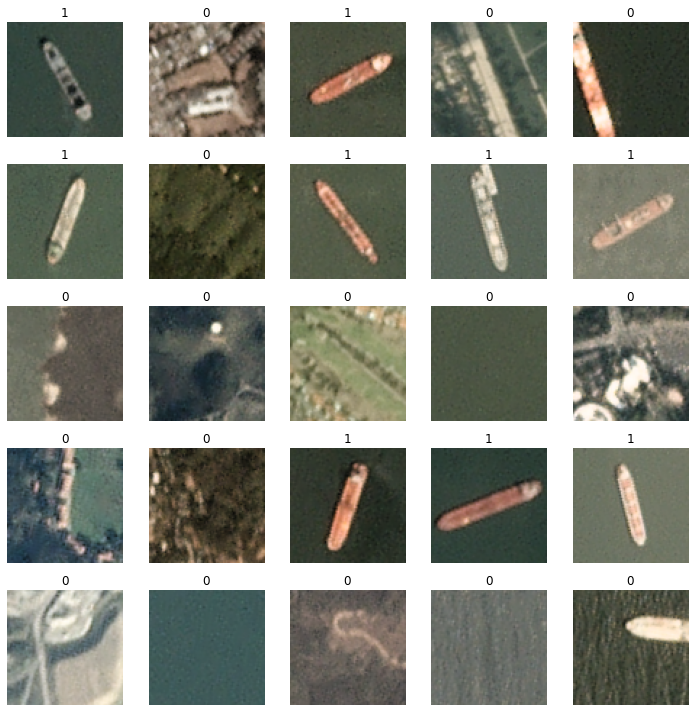

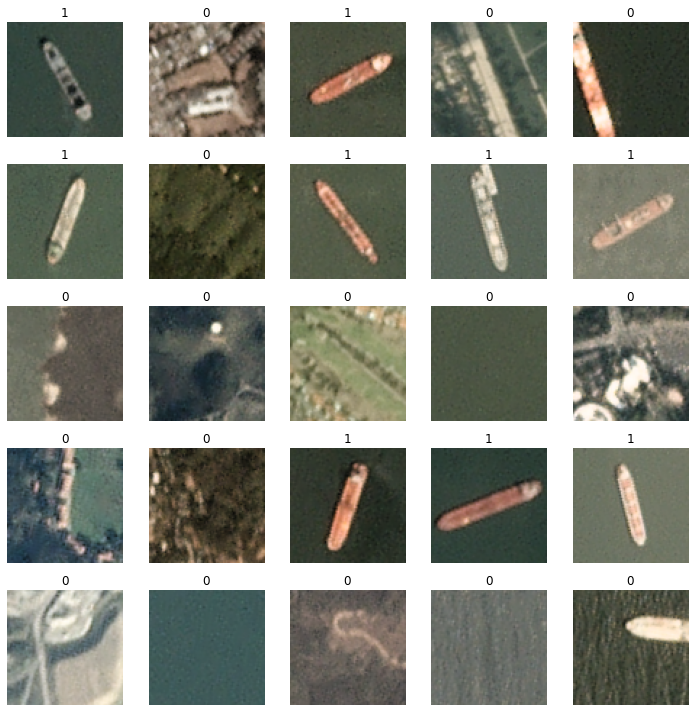

In [12]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.

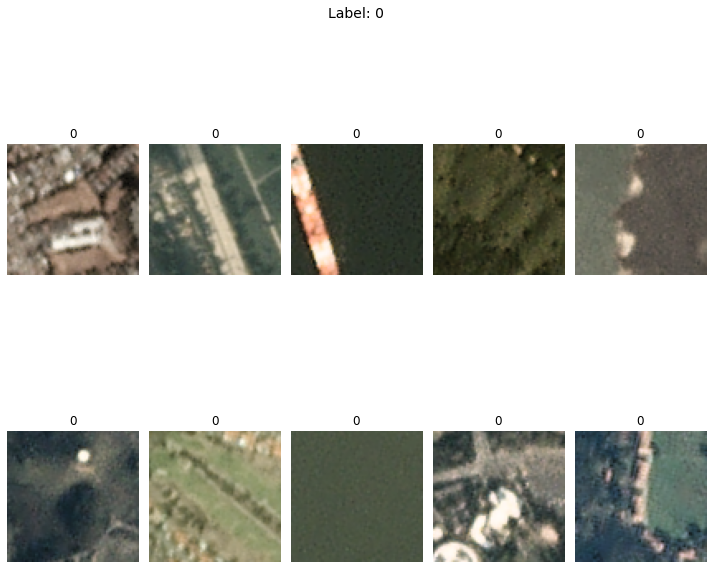

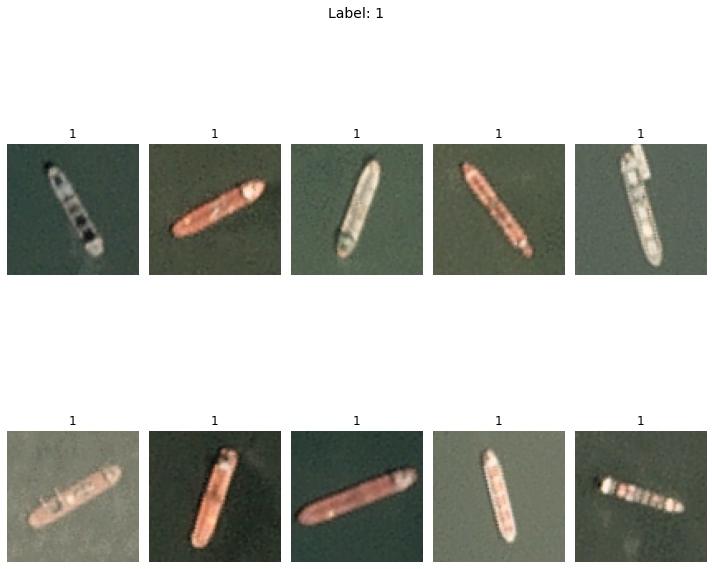

In [13]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ])
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")

# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our examples (`data`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values

In [14]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

### BEGIN SOLUTION
X = data / 255.
y = labels
### END SOLUTION

In [16]:
# Check if your solution is right 
assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )

# Split data into training data and testing data

To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [17]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing 32 features
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting. 
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 


In [18]:
# Set model0 equal to a Keras Sequential model
model0 = None

### BEGIN SOLUTION
# Set Classifier activation and loss depending on shape of target
if helper.y_OHE(y):
    num_cases = 2
    activation = "softmax"
    loss = 'categorical_crossentropy'
else:
    num_cases = 1
    activation = "sigmoid"
    loss = 'binary_crossentropy'
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model0 = Sequential()
model0.add(Conv2D(32, (3, 3), padding="same", input_shape=X.shape[1:], activation='relu', name='CNN_1'))
model0.add(Flatten())
model0.add(Dropout(0.2))
model0.add(Dense(num_cases, activation=activation, name='dense_head'))
### END SOLUTION

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 204801    
Total params: 205,697
Trainable params: 205,697
Non-trainable params: 0
_________________________________________________________________


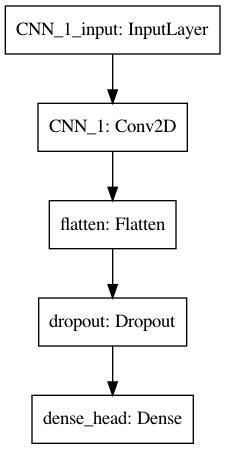

In [19]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:
- Name your model "CNN + Head" and store it in variable `model_name0`
- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training
- Save your training results in a variable named `history`
- Plot your training results using the`plotTrain` method described in the Student API above.



Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.6133 - accuracy: 0.8201 - val_loss: 0.2577 - val_accuracy: 0.8806
Epoch 2/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.2240 - accuracy: 0.9167 - val_loss: 0.1977 - val_accuracy: 0.9458
Epoch 3/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.1622 - accuracy: 0.9420 - val_loss: 0.1819 - val_accuracy: 0.9361
Epoch 4/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.1428 - accuracy: 0.9514 - val_loss: 0.1120 - val_accuracy: 0.9500
Epoch 5/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.1243 - accuracy: 0.9590 - val_loss: 0.1334 - val_accuracy: 0.9361
Epoch 6/10
2880/2880 [==============================] - 5s 2ms/sample - loss: 0.1066 - accuracy: 0.9618 - val_loss: 0.1235 - val_accuracy: 0.9597
Epoch 7/10
2880/2880 [==============================] - 5s 2ms/sample - loss:

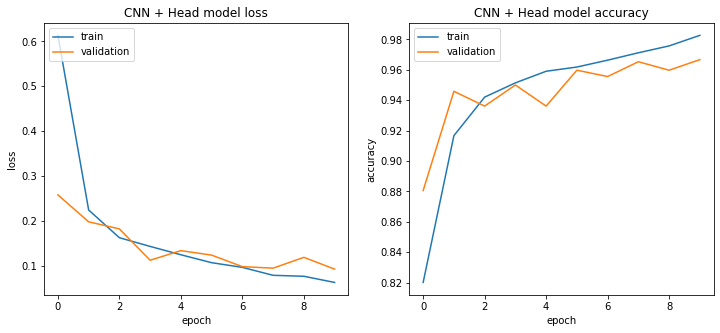

In [20]:
# Set the name and max_epochs of model0
model_name0 = "CNN + Head"
max_epochs = 10

### BEGIN SOLUTION
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
metrics = ['accuracy']

model0.compile(loss=loss, metrics=metrics)
history0 = model0.fit(X_train_, y_train_, epochs=max_epochs, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history0, model_name0)
### END SOLUTION

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model
- Set `num_parameters0` to be equal to the number of weights in your model

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.

In [21]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

### BEGIN SOLUTION
num_parameters0 = model0.count_params()
### END SOLUTION

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  205697


## Evaluate the model


**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [22]:
score0 = []

### BEGIN SOLUTION
score0 = model0.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

CNN + Head: Test loss: 0.15 / Test accuracy: 0.95


## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [23]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Model saved in directory ./models/CNN + Head; create an archive of this directory and submit with your assignment.
Directory ./models/CNN + Head already exists, files will be over-written.


In [ ]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - The first two Convolutional layers should have 32 features each.
        - Please name thee layers "CNN_1" and "CNN_2"
    - The last two Convolutional layers should have 64 features each.
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 
- Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [24]:
# Set model1 equal to a Keras Sequential model
model1 = None

### BEGIN SOLUTION
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu', name='CNN_1'))
model1.add(Conv2D(32, (3, 3), padding="same", activation='relu', name='CNN_2'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), padding="same", activation='relu', name='CNN_3'))
model1.add(Conv2D(64, (3, 3), padding="same", activation='relu', name='CNN_4'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(num_cases, activation=activation, name='dense_head'))
### END SOLUTION

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)       

In [ ]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`


Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 28s 10ms/sample - loss: 0.4445 - accuracy: 0.8222 - val_loss: 0.2174 - val_accuracy: 0.9153
Epoch 2/10
2880/2880 [==============================] - 25s 9ms/sample - loss: 0.2396 - accuracy: 0.9056 - val_loss: 0.1589 - val_accuracy: 0.9347
Epoch 3/10
2880/2880 [==============================] - 25s 9ms/sample - loss: 0.1944 - accuracy: 0.9240 - val_loss: 0.1484 - val_accuracy: 0.9389
Epoch 4/10
2880/2880 [==============================] - 25s 9ms/sample - loss: 0.1677 - accuracy: 0.9434 - val_loss: 0.1377 - val_accuracy: 0.9389
Epoch 5/10
2880/2880 [==============================] - 24s 8ms/sample - loss: 0.1176 - accuracy: 0.9563 - val_loss: 0.1092 - val_accuracy: 0.9569
Epoch 6/10
2880/2880 [==============================] - 26s 9ms/sample - loss: 0.1287 - accuracy: 0.9677 - val_loss: 0.3096 - val_accuracy: 0.8944
Epoch 7/10
2880/2880 [==============================] - 24s 8ms/sample

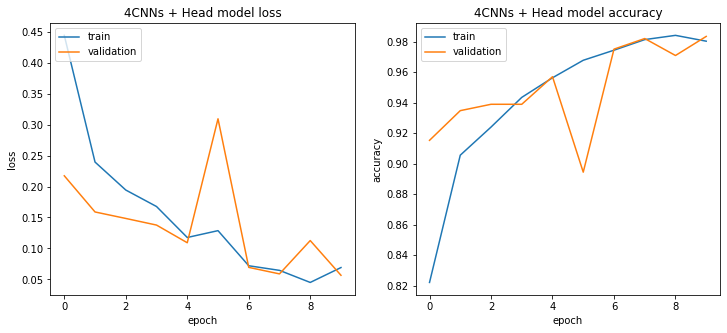

In [25]:
# Train the model using the API
model_name1 = "4CNNs + Head"

### BEGIN SOLUTION
model1.compile(loss=loss, metrics=metrics)
history1 = model1.fit(X_train_, y_train_, epochs=max_epochs, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history1, model_name1)
### END SOLUTION

## How many weights in this model ?

**Question:** 

Calculate the number of parameters in your new model.  
- Set `num_parameters1` to be equal to the number of parameters in your model.

In [26]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

### BEGIN SOLUTION
num_parameters1 = model1.count_params()
### END SOLUTION

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 91169


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  

In [27]:
score1 = []

### BEGIN SOLUTION
score1 = model1.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

4CNNs + Head: Test loss: 0.07 / Test accuracy: 0.99


Your test accuracy should be higher than before

# Save your trained model1 and history1

In [28]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Model saved in directory ./models/4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory ./models/4CNNs + Head already exists, files will be over-written.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.


## Now Submit your assignment!
Please click on the blue button <span style="color: blue;"> **Submit** </span> in the upper right corner of this notebook. 